# Plot Functional Groups
Project the representations of different functional groups, see if the network picks up on polarization

In [1]:
%matplotlib inline
from sklearn.manifold import Isomap, TSNE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
prop_cycle = plt.rcParams['axes.prop_cycle']
from matplotlib import colors
from matplotlib import cm
from jcesr_ml.benchmark import load_benchmark_data
from jcesr_ml.mpnn import set_custom_objects, run_model
from nfp.preprocessing import GraphSequence
from nfp.models import GraphModel
from keras.models import load_model
from rdkit import Chem
from tqdm import tqdm
import pickle as pkl
import pandas as pd
import numpy as np
import json
import os

Using TensorFlow backend.
/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)

Load the data, model and featurizer

In [2]:
set_custom_objects()

In [3]:
data = pd.read_pickle(os.path.join('..', 'partial-charges', 'mapped_charges_dataset.pkl.gz')).sample(2048, random_state=1)
model = load_model(os.path.join('..', 'mpnn', 'networks', 'single-task', '117232-entries', '128-nodes', '16384-batch_size', '1.00e-04-learning_rate', 'best_model.h5'))
untrained_model = load_model(os.path.join('..', 'mpnn', 'networks', 'single-task', 'architecture.h5'))
with open(os.path.join('..', 'mpnn', 'networks', 'single-task', 'converter.pkl'), 'rb') as fp:
    conv = pkl.load(fp)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/lus/theta-fs0/projects/CSC249ADCD08/solvation-energy-ml/env/lib/python3.6/site-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Define the [functional groups of interest](http://chemistry.elmhurst.edu/vchembook/213boilingpoint.html). These functional group swill be matched to auto-generated SMARTS strings from the group contribution modelling effort, which follow the pattern: `[<center-atom-type>X<center-atom-degree>H<bonded hydrogens>](<bonded-atoms-0>)`...`<bonded-atoms-*N-1*`. The bonded atoms are noted with their bond type and then sorted alphabetically. Names for these functional groups are tuples with the first item being the name of the group, and the second the degree (e.g., primary, secondary).

In [4]:
functional_groups = {
    ('alkyl', 1): '[CX4H3]C',
    ('alkyl', 2): '[CX4H2](C)C',
    ('alkyl', 3): '[CX4H1](C)(C)C',
    ('acid', 1): '[CX3H1](=O)(C)O',
    ('acid', 2): '[CX3H0](=O)(C)(C)O',
    ('amide', 1): '[CX3H0](=O)(C)N',
    ('alcohol', 1): '[CX4H2](C)O',
    ('alcohol', 2): '[CX4H1](C)(C)O',
    ('alcohol', 3): '[CX4H0](C)(C)(C)O',
    ('aldehyde', 1): '[CX3H1](=O)C',
    ('ketone', 1): '[CX3H0](=O)(C)C',
    ('amine', 1): '[CX4H2](C)N',
    ('amine', 2): '[CX4H1](C)(C)N',
    ('amine', 3): '[CX4H0](C)(C)(C)N',
    ('ester', 1): '[CX3H0](=O)(C)O',
}

## Extract the Graph Layer From the Network
We want the GRUStep layer that feeds into the Dense layer before the ReduceAtomToMol layer

In [5]:
rep_layer = model.get_layer('dense_1').input

In [6]:
rep_model = GraphModel(model.inputs, rep_layer)

In [7]:
untrained_rep_layer = untrained_model.get_layer('dense_1').input

In [8]:
untrained_rep_model = GraphModel(untrained_model.inputs, untrained_rep_layer)

## Load in the Group Contributions
In the previous notebook, we computed the contribution to solvation energy from many different types of atoms

In [9]:
groups = pd.read_json(os.path.join('..', 'group-contribution', 'lasso_coef.json'), orient='index')
print(f'Loaded {len(groups)} groups')

Loaded 135 groups


Parse the index tag

In [10]:
groups['type'] = groups.index.map(lambda x: json.loads(x)[0])
groups['bonds'] = groups.index.map(lambda x: json.loads(x)[1])
groups['n_hydro'] = groups.index.map(lambda x: json.loads(x)[2])

Make a smarts from the index

In [11]:
def conv_to_smarts(notation):
    """Convert the index of the group attention array to SMARTS"""
    key = json.loads(notation)
    n_bonds = len(key[1]) + key[2]
    if len(key[1]) > 0:
        groups = ''.join([f'({x})' for x in key[1][:-1]]) + key[1][-1]
    else:
        groups = ''
    return f'[{key[0]}X{n_bonds}H{key[2]}]{groups}' 
groups['smarts'] = groups.index.map(conv_to_smarts)

Skip those with a zero contribution to solvation energy in our group model

In [12]:
groups.query('coef != 0', inplace=True)
print(f'Found {len(groups)} groups with non-zero contributions, with a total of {groups["count"].sum()} atoms')

Found 73 groups with non-zero contributions, with a total of 961544 atoms


Label some groups

In [13]:
groups['name'] = None
groups['degree'] = None

In [14]:
for (name, degree), smarts in functional_groups.items():
    entry = groups.query(f'smarts=="{smarts}"')
    if len(entry) > 0:
        groups.loc[entry.index, 'name'] = name
        groups.loc[entry.index, 'degree'] = degree
print(f'Found {sum(np.logical_not(groups["name"].isnull()))} named functional groups')

Found 12 named functional groups


## Make Utility Functions
We need a function to get atoms which match a certain functional group pattern and another to get the representation for that atom

In [15]:
def get_matches(smiles, func):
    """Get carbon atoms with match a certain funcitonal group pattern
    
    Args:
        smiles (str): SMILES string of molecule of interest
        func (str): SMARTS string of functional group. First atom in SMARTS must be the target atom
    Returns:
        ([int]) List of the matching atoms
    """
    
    # Read the SMILES and SMARTS
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    patt = Chem.MolFromSmarts(func)
    if patt is None:
        raise ValueError(f'Bad SMARTS: {func}')
    
    # Attempt to match
    match = mol.GetSubstructMatches(patt)
    
    # Return the atoms which match
    return set([m[0] for m in match])

In [16]:
assert get_matches('C', '[C]') == {0}
assert get_matches('CCO', '[CX4H2]O') == {1}
assert get_matches('C(=O)O', '[CX3](=O)[OX2H1]') == {0}

In [17]:
def get_representation(model, conv, smiles):
    """Get the representation for each model"""
    # Turn the molecule into a graph sequence
    g = GraphSequence([conv.construct_feature_matrices(smiles)])
    
    # Pipe the sequence through the model
    return model.predict_on_batch(g[0])

In [18]:
def get_reps_of_functional_groups(smiles, func, conv, charges=None, **kwargs):
    """Get the representation of atoms which match a certain functional group pattern

    Args:
        smiles (str): SMILES string of molecule of interest
        func (str): SMARTS string of functional group. First atom in SMARTS must be the target atom
        conv (SmilesPreprocessor): Tool to create graph representation from SMILES string
        charges ([float]): Partial charges for each atom
    """
    # Match atoms from the smiles string
    matching_atoms = get_matches(smiles, func)
    if len(matching_atoms) == 0:
        return None
    
    # Generate the representations
    rep = get_representation(rep_model, conv, smiles)
    untrained_rep = get_representation(untrained_rep_model, conv, smiles)
    if charges is None:
        return rep[list(matching_atoms), :]
    return rep[list(matching_atoms), :], untrained_rep[list(matching_atoms), :],\
        np.array(charges)[list(matching_atoms)], [kwargs.get('sol_water', None)]*len(matching_atoms)   

In [19]:
assert get_reps_of_functional_groups('CCO', '[CX4H2]O', conv, [-1, -2, -3] + [0]*6)[0].shape == (1, 128)

In [20]:
assert get_reps_of_functional_groups('CCO', '[CX4H2]O', conv, [-1, -2, -3] + [0]*6)[2] == [-2]

## Compute the Representations and Gather Partial Charges
Use the machine learning model to get the representation of all functional groups, functional 

In [21]:
allreps = []
allureps = []
allcharges = []
allsols = []
for rid, row in tqdm(groups.iterrows(), total=len(groups)):
    func = lambda x: get_reps_of_functional_groups(x['smiles_0'], row['smarts'], conv, 
                                                   charges=x['mapped_charges'], sol_water=x['sol_water'])
    output = tuple(zip(*filter(lambda x: x is not None, data.apply(func, axis=1))))
    if len(output) > 0:
        reps, untrained_reps, charges, sols = output
        allsols.append(np.concatenate(sols))
        allreps.append(np.concatenate(reps))
        allcharges.append(np.concatenate(charges))
        allureps.append(np.concatenate(untrained_reps))
    else:
        allreps.append([])
        allcharges.append([])
        allsols.append([])
        allureps.append([])
groups['reps'] = allreps
groups['ureps'] = allureps
groups['charges'] = allcharges
groups['sols'] = allsols

100%|██████████| 73/73 [01:57<00:00,  1.61s/it]


Filter out groups that don't match with this dataset

In [22]:
groups = groups[groups['reps'].apply(len) > 0]
print(f'Matched a total of {len(groups)} groups with a total of {groups["reps"].apply(len).sum()} atoms')

Matched a total of 40 groups with a total of 14321 atoms


## Compute Low-Dimensional Versions of the Representations
So that we can visualize them. We choose IsoMap as it is fast and tries to preserve distances, which we care more about than directions (a la PCA).

We also compute the t-SNE representations, which has a similar "distance-preserving" nature and a tendancy to form clusters in data. The clusters will aid our analysis

In [23]:
all_reps = np.concatenate([x for x in groups['reps']])
print(f'Shape of the representation matrix: {all_reps.shape}')

Shape of the representation matrix: (14321, 128)


We are going to use a downsampled version of the dataset for computational efficiency.
We weigh the likelihood of choosing a point based on the number of entries for that group,
so that we get samples from each group.

In [24]:
groups['count'] = groups['reps'].apply(len)

In [25]:
downsampled_reps = all_reps[np.random.choice(all_reps.shape[0], size=2048, replace=False,
                                             p=np.repeat(1.0 / groups['count'], groups['count']) / len(groups)), :]
print(f'Downsampled shape: {downsampled_reps.shape}')

Downsampled shape: (2048, 128)


Compute representations for the 1D and 2D cases. 
IsoMap has a parameter that controls how many NNs are considered when assessing
distances. We are going to use a realatively large number to make longer-range 
distances impact the model

In [26]:
for d in tqdm([1, 2]):
    # Fit model
    isomap = Pipeline([
        ('scale', RobustScaler()),
        ('isomap', Isomap(n_components=d, n_neighbors=64, n_jobs=-1))
    ])
    isomap.fit_transform(downsampled_reps)
    
    # Apply it to all subsets
    groups[f'rep_{d}d'] = groups['reps'].apply(isomap.transform)

100%|██████████| 2/2 [01:06<00:00, 33.39s/it]


Do something similar for t-SNE

In [28]:
tsne = Pipeline([
    ('scale', RobustScaler()),
    ('pca', PCA(n_components=32)),
    ('tsne', TSNE(perplexity=200, n_iter=20000))
])

for r in tqdm(['reps', 'ureps']):
    # Get the desired representation
    all_reps = np.concatenate([x for x in groups[r]])
    
    # Compute the reps for all groups
    X = tsne.fit_transform(all_reps)
    
    # Break it up for each group
    reps_per_group = np.split(X, groups['count'].cumsum()[:-1])
    groups[f'tsne_{r}'] = reps_per_group

100%|██████████| 2/2 [1:36:41<00:00, 2900.91s/it]


## Investigate Tie between Partial Charge, Solvation Energy and MPNN Representations
We want to see how whether these groups correspond well to each other

In [29]:
range_1d = (np.percentile(np.concatenate(groups['rep_1d']).ravel(), 1), np.percentile(np.concatenate(groups['rep_1d']).ravel(), 99))

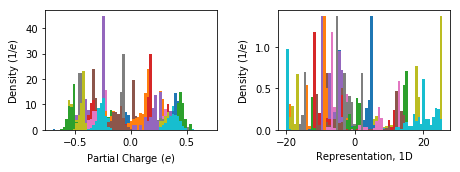

In [30]:
fig, axs = plt.subplots(1, 2, sharey=False, figsize=(6.5, 2.5))

charge_bins = np.linspace(-0.7, 0.7, 64)
rep_bins = np.linspace(*range_1d, 64)
for name, group in groups.iterrows():
    axs[0].hist(group['charges'], bins=charge_bins, density=True)
    axs[1].hist(group['rep_1d'], bins=rep_bins, density=True)

axs[0].set_xlabel('Partial Charge ($e$)')
axs[1].set_xlabel('Representation, 1D')
for ax in axs:
    ax.set_ylabel('Density (1/$e$)')
fig.tight_layout()

*Finding*: I don't see much here. Types are really clusters

Plot the charge vs the representaiton, color by the type of the atom

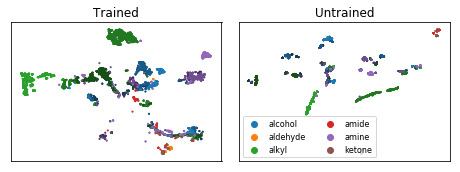

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 2.5))

for r, ax in zip(['reps', 'ureps'], axs):
    for (gid, group), color in zip(groups.query('name!=None and type=="C"').groupby('name'), prop_cycle.by_key()["color"]):
        c = np.array(np.multiply((np.repeat((4 - group['degree'] + 1) / 4, group['count']))[:, None], [colors.to_rgb(color)]), dtype=float)
        X = np.concatenate(group[f'tsne_{r}'])
        ax.scatter(X[:, 0], X[:, 1], c=c, s=4.5, edgecolor='none', vmin=-2.5, vmax=1.5)
        ax.scatter([], [], label=gid)
        ax.set_title('Trained' if r == 'reps' else 'Untrained')

axs[1].legend(ncol=2, fontsize=8)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
fig.savefig(os.path.join('figures', 'atom-2d-rep.png'), dpi=320)

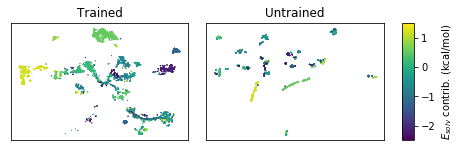

In [46]:
fig, axs = plt.subplots(1, 3, figsize=(6.5, 2.2), gridspec_kw={'width_ratios': [1, 1, 0.07]})

for r, ax in zip(['reps', 'ureps'], axs):
    for gid, group in groups.query('type=="C"').groupby('smarts'):
        c = np.repeat(group['coef'], group['count'])
        X = np.concatenate(group[f'tsne_{r}'])
        c= ax.scatter(X[:, 0], X[:, 1], 
                      c=c, s=1.5, edgecolor='none', vmin=-2.5, vmax=1.5, zorder=-float(group['coef']))
    ax.set_title('Trained' if r == 'reps' else 'Untrained')
    
c = ax.scatter([], [], c=[], vmin=-2.5, vmax=1.5)
for ax in axs[:2]:
    ax.set_xticks([])
    ax.set_yticks([])

fig.colorbar(c, label='$E_{solv}$ contrib. (kcal/mol)', cax=axs[2])
fig.tight_layout()
fig.savefig(os.path.join('figures', 'atom-rep-vs-contrib-plot.png'), dpi=320)